In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc
from scipy import optimize as opt
from collections import defaultdict

SAMPLING_E_ATOL = 2e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 256
MAX_SAMPLES = 32768
SAMPLING_CONF_IDX = 1
EXACT_SAMPLES = MAX_SAMPLES*4

BETA_MIN = -np.pi/4
BETA_MAX = np.pi/4
GAMMA_MIN = -np.pi/2
GAMMA_MAX = np.pi/2

CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

Max cost: 6


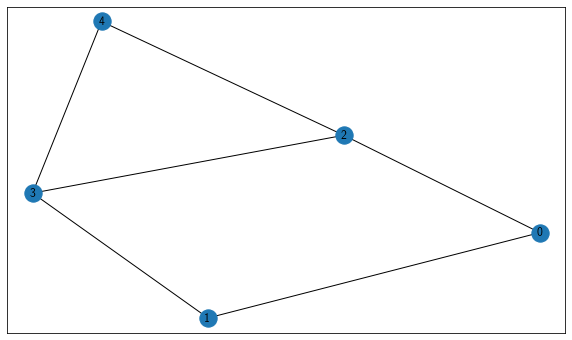

In [2]:
k_cuts=2
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,2.0),(2,3,1.5),(3,1,1.1),(3,4,0.4),(4,2,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,pos=pos)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G, k_cuts)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')

In [4]:
def getval(x,history_ref,backend,depth,version,noisemodel,E_atol,E_rtol,dv_rtol,min_n_shots,max_n_shots,conf_idx):
    circuit = createCircuit_MaxCut(x,G,depth,k_cuts,version)
    
    raw_data = defaultdict(float)
    [E_list,v_list,n_list] = sampleUntilPrecision(circuit,backend,noisemodel,min_n_shots,
                                                         max_n_shots,E_atol,E_rtol,dv_rtol,conf_idx, measurementStatistics_MaxCut, measurement_vars={'G' : G, 'k_cuts' : k_cuts})

    history_ref['gammas'].append(x[0])
    history_ref['betas'].append(x[1])
    history_ref['expectations'].append(E_list)
    history_ref['variances'].append(v_list)
    history_ref['n_shots'].append(n_list)
        
    return -E_list[-1]

In [5]:
opt_history = {
    'gammas': [],
    'betas': [],
    'expectations': [],
    'variances': [],
    'n_shots': [],
}
x0 = (0.3,0.3)
out = opt.minimize(getval, x0=x0, method='COBYLA',
                 args=(opt_history,backend_sim,CIRCUIT_DEPTH,CIRCUIT_VERSION,None,
                       SAMPLING_E_ATOL,SAMPLING_E_RTOL,SAMPLING_DELTA_V_RTOL,
                       MIN_SAMPLES,MAX_SAMPLES,SAMPLING_CONF_IDX),
                 options={'rhobeg': 1e-1, 'disp': True})

In [6]:
max_reps = max([len(x) for x in opt_history['n_shots']])
Ess = np.array(np.array([x + [x[-1]]*(max_reps-len(x)+1) for x in opt_history['expectations']]))
vss = np.array(np.array([x + [x[-1]]*(max_reps-len(x)+1) for x in opt_history['variances']]))
nss = np.array(np.array([x + [0]*(max_reps-len(x)+1) for x in opt_history['n_shots']]))

first_Es = Ess[:,0]
first_vs = vss[:,0]
first_ns = nss[:,0]

last_Es = Ess[:,-1]
last_vs = vss[:,-1]
last_ns = np.sum(nss,axis=1)

first_stddevs = np.sqrt(first_vs)
first_stderrs = np.divide(first_stddevs,np.sqrt(first_ns))
last_stddevs = np.sqrt(last_vs)
last_stderrs = np.divide(first_stddevs,np.sqrt(last_ns))

gammas = np.array(opt_history['gammas'])
betas = np.array(opt_history['betas'])
its = list(range(nss.shape[0]))
n_its = len(its)

Es_exact = np.zeros((n_its,))
for it in its:
    circuit = createCircuit_MaxCut(np.array((gammas[it],betas[it])),G,CIRCUIT_DEPTH,k_cuts,CIRCUIT_VERSION)
    job_sim_exact = execute(circuit, backend_sim, shots=EXACT_SAMPLES)
    [E_exact],_,_ = measurementStatistics_MaxCut(job_sim_exact.result().results, options={'G' : G, 'k_cuts' : k_cuts})
    Es_exact[it] = E_exact

Text(0.5, 1.0, 'Sample counts')

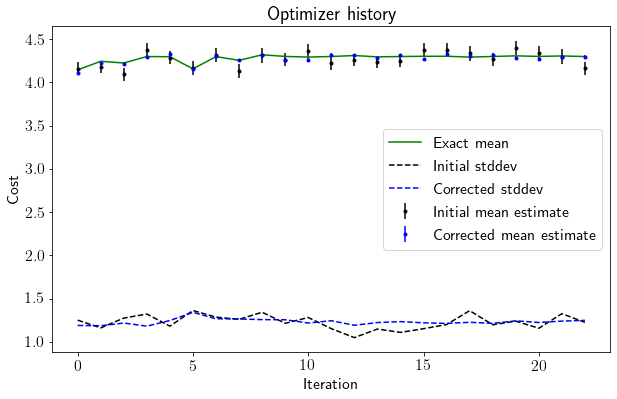

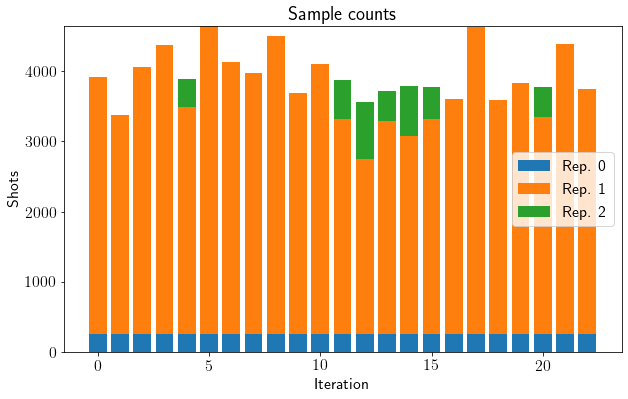

In [7]:
pl.figure(figsize=(10,6))
pl.plot(its,Es_exact,'g-',label='Exact mean')
pl.errorbar(its,first_Es,yerr=first_stderrs.flatten(),fmt='.k',label='Initial mean estimate')
pl.errorbar(its,last_Es,yerr=last_stderrs.flatten(),fmt='.b',label='Corrected mean estimate')
pl.plot(its,first_stddevs,'k--',label='Initial stddev')
pl.plot(its,last_stddevs,'b--',label='Corrected stddev')
pl.legend()
pl.xlabel('Iteration')
pl.ylabel('Cost')
pl.title('Optimizer history')

pl.figure(figsize=(10,6))
pl.bar(its,nss[:,0],label='Rep. 0')
for i in range(1,max_reps):
    pl.bar(its,nss[:,i],bottom=np.sum(nss[:,0:i],axis=1),label='Rep. %d'%i)
pl.legend()
pl.xlabel('Iteration')
pl.ylabel('Shots')
pl.title('Sample counts')

<ipython-input-8-4944884a9541>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
<ipython-input-8-4944884a9541>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis


Text(0.5, 1.0, 'Relative error confidence')

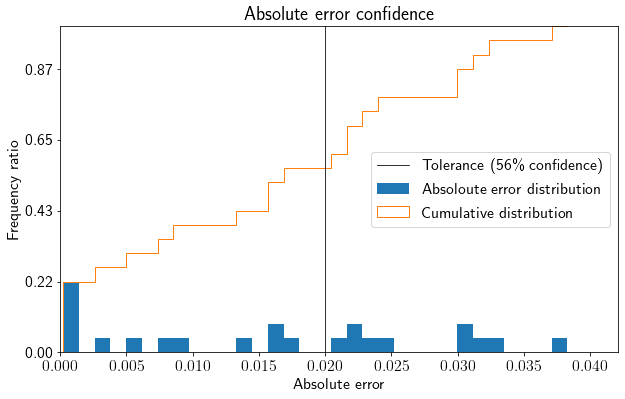

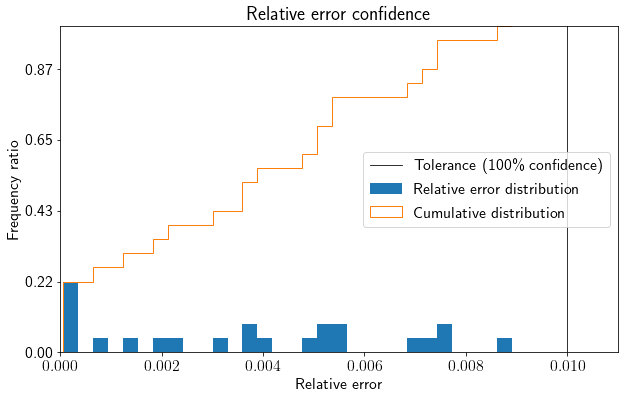

In [8]:
n_iterations = len(its)

abs_errors = np.array([abs(Es_exact[it] - last_Es[it]) for it in its])
rel_errors = np.array([abs_errors[it]/Es_exact[it] for it in its])

abs_binsize = 0.06*SAMPLING_E_ATOL
rel_binsize = 0.03*SAMPLING_E_RTOL
abs_n_bins = int(np.ceil(max(abs_errors)/abs_binsize))
rel_n_bins = int(np.ceil(max(rel_errors)/rel_binsize))

abs_bounded_count = np.size(np.where(abs_errors <= SAMPLING_E_ATOL))
rel_bounded_count = np.size(np.where(rel_errors <= SAMPLING_E_RTOL))
abs_bounded_pct = int(100*abs_bounded_count/n_iterations)
rel_bounded_pct = int(100*rel_bounded_count/n_iterations)
    
pl.figure(figsize=(10,6))
pl.hist(abs_errors,abs_n_bins,label='Absoloute error distribution')
_,_,patches = pl.hist(abs_errors,abs_n_bins,cumulative=True,histtype='step',label='Cumulative distribution')
patches[0].set_xy(patches[0].get_xy()[:-1]) # Delete last point which is at y=0
pl.axvline(SAMPLING_E_ATOL,linestyle='-',linewidth=0.8,color='k',
           label='Tolerance (%d\%% confidence)' % abs_bounded_pct)
ax = pl.gca()
yticks = ax.get_yticks()
ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
ax.margins(x=0)
pl.xlabel('Absolute error')
pl.ylabel('Frequency ratio')
pl.xlim(0,max(SAMPLING_E_ATOL,max(abs_errors))*1.1)
pl.ylim(0,n_iterations)
pl.legend(loc='center right')
pl.title('Absolute error confidence')

pl.figure(figsize=(10,6))
pl.hist(rel_errors,rel_n_bins,label='Relative error distribution')
_,_,patches = pl.hist(rel_errors,rel_n_bins,cumulative=True,histtype='step',label='Cumulative distribution')
patches[0].set_xy(patches[0].get_xy()[:-1]) # Delete last point which is at y=0
pl.axvline(SAMPLING_E_RTOL,linestyle='-',linewidth=0.8,color='k',
           label='Tolerance (%d\%% confidence)' % rel_bounded_pct)
ax = pl.gca()
yticks = ax.get_yticks()
ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
ax.margins(x=0)
pl.xlabel('Relative error')
pl.ylabel('Frequency ratio')
pl.xlim(0,max(SAMPLING_E_RTOL,max(rel_errors))*1.1)
pl.ylim(0,n_iterations)
pl.legend(loc='center right')
pl.title('Relative error confidence')